In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: /workspaces/systematic-trading-framework


In [2]:
import matplotlib.pyplot as plt

from src.data.loaders import load_ohlcv
from src.data.validation import validate_ohlcv
from src.features import add_close_returns, add_volatility_features
from src.features.technical.trend import (
    add_trend_features,
    add_trend_regime_features,
)
from src.backtesting.engine import run_backtest
from src.backtesting.strategies import (
    buy_and_hold_signal,
    trend_state_long_only_signal,
)


In [3]:
df = load_ohlcv("SPY", start="2015-01-01", interval="1d")
validate_ohlcv(df)

df = add_close_returns(df, log=True)
df = add_volatility_features(df, returns_col="close_logret")

df = add_trend_features(
    df,
    price_col="close",
    sma_windows=(20, 50),
    ema_spans=(20,),
)

df = add_trend_regime_features(
    df,
    price_col="close",
    base_sma_for_sign=50,
    short_sma=20,
    long_sma=50,
)

df.tail()


Price,open,high,low,close,volume,close_logret,vol_rolling_10,vol_rolling_20,vol_rolling_60,vol_ewma_10,vol_ewma_20,close_sma_20,close_over_sma_20,close_sma_50,close_over_sma_50,close_ema_20,close_over_ema_20,close_trend_regime_sma_50,close_trend_state_sma_20_50
Date,,,,,,,,,,,,,,,,,,,
2026-01-21,679.650024,688.739990,678.130005,685.400024,127844500,0.011475,0.133733,0.107342,0.119379,0.163500,0.132271,688.614499,-0.004668,681.416201,0.005846,687.328458,-0.002806,1.0,1.0
2026-01-22,689.849976,691.130005,686.919983,688.979980,77112200,0.005210,0.136356,0.106674,0.118710,0.152931,0.128534,688.821997,0.000229,681.776401,0.010566,687.485746,0.002173,1.0,1.0
2026-01-23,688.150024,690.960022,687.159973,689.229980,63059600,0.000363,0.136375,0.105486,0.116292,0.138333,0.122262,688.885495,0.000500,681.932201,0.010702,687.651863,0.002295,1.0,1.0
2026-01-26,690.489990,694.130005,689.919983,692.729980,60473800,0.005065,0.134499,0.106295,0.116623,0.128866,0.118555,689.002994,0.005409,682.126801,0.015544,688.135493,0.006677,1.0,1.0
2026-01-27,694.179993,696.530029,693.575012,695.489990,54801663,0.003976,0.135917,0.107139,0.116887,0.117975,0.113849,689.261993,0.009036,682.369000,0.019229,688.835922,0.009660,1.0,1.0


In [4]:
df["signal_buy_and_hold"] = buy_and_hold_signal(df)
df["signal_trend_state_long_only"] = trend_state_long_only_signal(
    df,
    state_col="close_trend_state_sma_20_50",
)


In [5]:
res_bh = run_backtest(
    df,
    signal_col="signal_buy_and_hold",
    returns_col="close_logret",
    cost_per_unit_turnover=0.0005,
)

res_trend = run_backtest(
    df,
    signal_col="signal_trend_state_long_only",
    returns_col="close_logret",
    cost_per_unit_turnover=0.0005,
)

res_bh.summary, res_trend.summary


({'total_return': 1.8884595832594218,
  'max_drawdown': -0.3613995599472961,
  'annualized_return': 0.09896691251997325,
  'annualized_vol': 0.17865039657590367,
  'sharpe': 0.5539697331593939},
 {'total_return': 0.8532298521828903,
  'max_drawdown': -0.31004224698486693,
  'annualized_return': 0.0574738949099185,
  'annualized_vol': 0.11243123023653209,
  'sharpe': 0.5111915505060765})

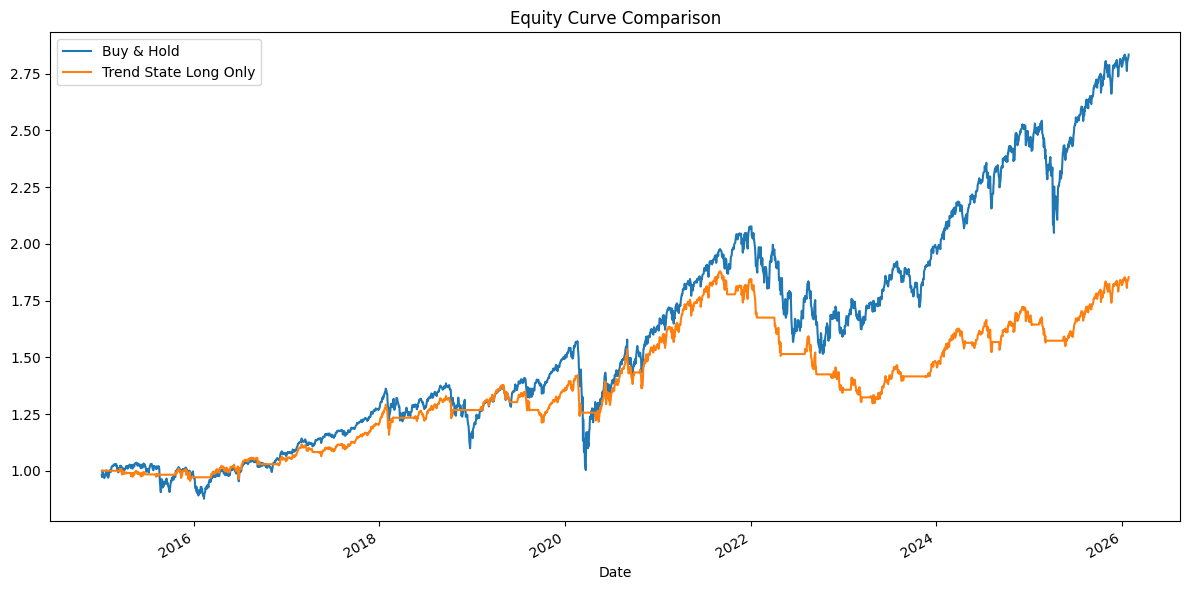

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

res_bh.equity_curve.plot(ax=ax, label="Buy & Hold")
res_trend.equity_curve.plot(ax=ax, label="Trend State Long Only")

ax.set_title("Equity Curve Comparison")
ax.legend()
plt.tight_layout()
